name: Razan Maree, ID: 314893520

name: Abed Alftah Abed Alftah, ID: 206529836

# Deep Q-Network for Cart-Pole.

In this assignment you are required to implement a Deep Q-Network agent, for the Cart-Pole problem.

You need to submit your code, along with a plot of the rewards during training, and a video of an episode with the trained agent.


__Frameworks__ - we'll accept this homework in any deep learning framework. This particular notebook was designed for PyTorch, but you'll find it easy to adapt it to almost any Python-based deep learning framework.

In [1]:
!pip install stable-baselines3 gym==0.22.0
!pip install pyglet==1.5.27
!pip install pyvirtualdisplay

In [4]:
import os
import random
import numpy as np
import torch
import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display

if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !apt-get -qq install -y xvfb
    os.environ['DISPLAY'] = ':1'

display = Display(visible=0, size=(400, 300))
display.start()


## Cart Pole

In this environment a pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The pendulum is placed upright on the cart and the goal is to balance the pole by applying forces in the left and right direction on the cart.

The observation consists of the cart position, cart velocity, pole angle and pole angular velocity.

There are 2 actions corresponding to moving the cart to the left and to the right.

See full description [here](https://www.gymlibrary.dev/environments/classic_control/cart_pole/).



In [2]:
ENV_NAME = "CartPole-v0"

def make_env(seed=None):
    # some envs are wrapped with a time limit wrapper by default
    env = gym.make(ENV_NAME).unwrapped
    if seed is not None:
        env.seed(seed)
    return env

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:505: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1` with the environment ID `CartPole-v1`.
  logger.warn(


observation dim (4,) number of actions 2


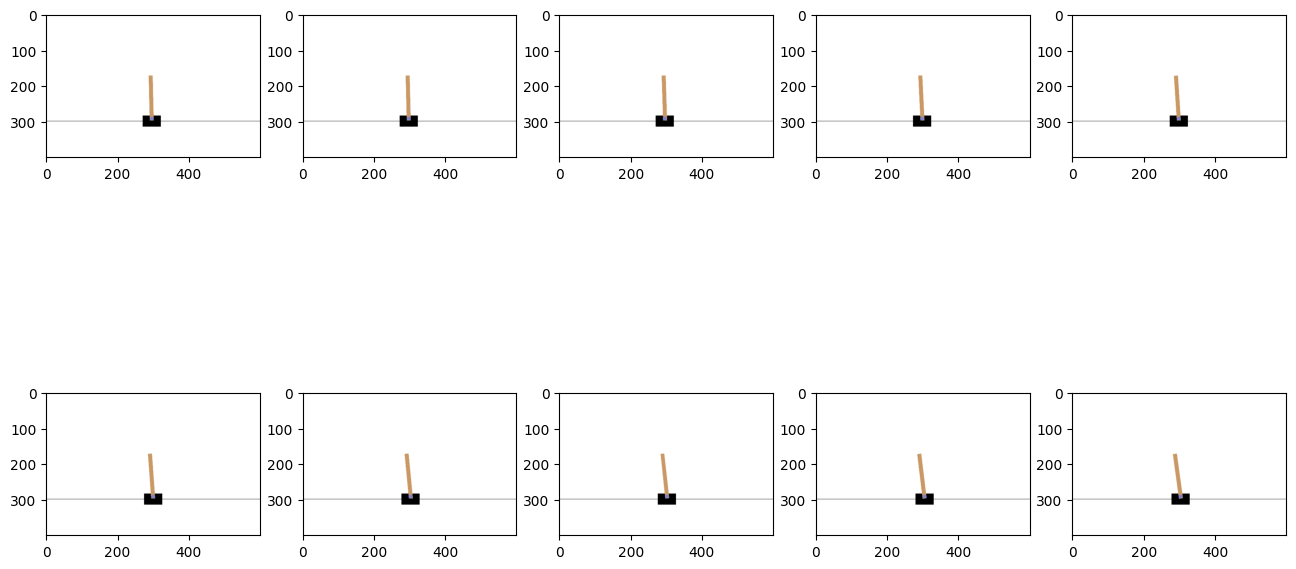

In [5]:
env = gym.make(ENV_NAME)
obs = env.reset()


n_actions = env.action_space.n
obs_dim = obs.shape
print("observation dim", obs_dim, "number of actions", n_actions)

n_cols = 5
n_rows = 2
fig = plt.figure(figsize=(16, 9))

for row in range(n_rows):
    for col in range(n_cols):
        ax = fig.add_subplot(n_rows, n_cols, row * n_cols + col + 1)
        ax.imshow(env.render('rgb_array'))
        env.step(env.action_space.sample())
plt.show()

## Random Agent

Here we implement a random agent to use in the 'evaluate' function, that runs the agent through multiple epsiodes.

In [4]:
class RandomAgent():
    def __init__(self, n_actions):
        self.n_actions = n_actions


    def get_qvalues(self, states):
        return np.random.normal(size=(1,self.n_actions,))

    def sample_actions(self, qvalues):
        return np.random.randint(self.n_actions, size=(1,))

In [5]:
def evaluate(env, agent, n_games=1, greedy=False, t_max=10000):
    """ Plays n_games full games. If greedy, picks actions as argmax(qvalues). Returns mean reward. """
    rewards = []
    for _ in range(n_games):
        s = env.reset()
        reward = 0
        for _ in range(t_max):
            qvalues = agent.get_qvalues([s])
            action = qvalues.argmax(axis=-1)[0] if greedy else agent.sample_actions(qvalues)[0]
            s, r, done, _ = env.step(action)
            reward += r
            if done:
              break

        rewards.append(reward)
    return np.mean(rewards)

agent = RandomAgent(n_actions)
mean_reward = evaluate(env, agent, greedy=True, n_games=5)

## Video generation

In [7]:
# run sessions

import gym.wrappers
import sys
from pathlib import Path
from base64 import b64encode
from IPython.display import HTML

n_games = 1 # how many games to record

with gym.wrappers.Monitor(make_env(), directory="videos", force=True) as env_monitor:
    env_monitor.reset()
    sessions = [evaluate(env_monitor, agent, n_games=1, greedy=False)]


In [8]:
# show video

video_paths = sorted([s for s in Path('videos').iterdir() if s.suffix == '.mp4'])
print(len(video_paths))
video_path = video_paths[-1]  # You can also try other indices (if n_games>1)

if 'google.colab' in sys.modules:
    # https://stackoverflow.com/a/57378660/1214547
    with video_path.open('rb') as fp:
        mp4 = fp.read()
    data_url = 'data:video/mp4;base64,' + b64encode(mp4).decode()
else:
    data_url = str(video_path)

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(data_url))

2


## Assignment

Implement a DQN agent that contains:
1. A neural network that predicts the q-values for a given observation.
2. An experience replay buffer where all transitions are added.
3. A target Q-network that is formed by periodically copying the weights of the main Q-nework.

You will also need to implement the training loop, and submit a figure showing the reward as a function of the training step, and a video showing an episode with the trained agent.

In [6]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

class DQN(nn.Module):
    def __init__(self, observation_space, action_space):
        super(DQN, self).__init__()
        self.observation_space = observation_space
        self.action_space = action_space

        self.fc1 = nn.Linear(self.observation_space, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, self.action_space)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [7]:
class DQNAgent:
    def __init__(self, input_size, output_size, lr=0.001, gamma=0.99, epsilon=1.0, epsilon_min=0.01,
                 epsilon_decay=0.995, target_update=10, batch_size=64, capacity=10000):
        self.input_size = input_size
        self.output_size = output_size
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.target_update = target_update
        self.batch_size = batch_size
        self.memory = []
        self.capacity = capacity
        self.steps = 0

        self.q_network = DQN(input_size, output_size)
        self.target_network = DQN(input_size, output_size)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.target_network.eval()
        self.q_network.to(device)
        self.target_network.to(device)

        # Define optimizer and loss function
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)
        self.loss_fn = nn.MSELoss()

    def select_action(self, state):
        # Epsilon-greedy policy
        if random.random() < self.epsilon:
            return random.randint(0, self.output_size - 1)
        else:
            with torch.no_grad():
                q_values = self.q_network(state)
                return q_values.argmax().item()

    def remember(self, experience):
        if len(self.memory) < self.capacity:
            self.memory.append(experience)
        else:
            self.memory.pop(0)
            self.memory.append(experience)

    def replay(self):
        if len(self.memory) < self.batch_size:
            return

        batch = random.sample(self.memory, self.batch_size)
        states, actions, next_states, rewards, dones = zip(*batch)
        states = np.array(states)
        next_states = np.array(next_states)
        states = torch.tensor(states, dtype=torch.float32).to(device)
        actions = torch.tensor(actions, dtype=torch.int64).unsqueeze(1).to(device)
        next_states = torch.tensor(next_states, dtype=torch.float32).to(device)
        rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
        dones = torch.tensor(dones, dtype=torch.bool).to(device)

        q_values = self.q_network(states).gather(1, actions)

        next_q_values = self.target_network(next_states).max(1)[0].detach()
        target_q_values = rewards.unsqueeze(1) + (
                1 - dones.unsqueeze(1).float()) * self.gamma * next_q_values.unsqueeze(1)
        loss = self.loss_fn(q_values, target_q_values)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update epsilon
        self.steps += 1
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

        # Update target network
        if self.steps % self.target_update == 0:
            self.target_network.load_state_dict(self.q_network.state_dict())
print(obs_dim, n_actions)
agent = DQNAgent(obs_dim[0], n_actions)

(4,) 2


Episode 0, Reward: 15.0
Episode 10, Reward: 11.0
Episode 20, Reward: 34.0
Episode 30, Reward: 33.0
Episode 40, Reward: 147.0
Episode 50, Reward: 121.0
Episode 60, Reward: 200.0
Episode 70, Reward: 200.0
Episode 80, Reward: 200.0
Episode 90, Reward: 200.0
Episode 100, Reward: 200.0
Episode 110, Reward: 198.0
Episode 120, Reward: 200.0
Episode 130, Reward: 200.0
Episode 140, Reward: 200.0
Episode 150, Reward: 200.0
Episode 160, Reward: 200.0
Episode 170, Reward: 200.0
Episode 180, Reward: 200.0
Episode 190, Reward: 200.0
Episode 200, Reward: 200.0
Episode 210, Reward: 200.0
Episode 220, Reward: 200.0
Episode 230, Reward: 200.0
Episode 240, Reward: 200.0
Episode 250, Reward: 48.0
Episode 260, Reward: 45.0
Episode 270, Reward: 200.0
Episode 280, Reward: 200.0
Episode 290, Reward: 168.0
Episode 300, Reward: 160.0
Episode 310, Reward: 200.0
Episode 320, Reward: 167.0
Episode 330, Reward: 200.0
Episode 340, Reward: 158.0
Episode 350, Reward: 200.0
Episode 360, Reward: 9.0
Episode 370, Reward:

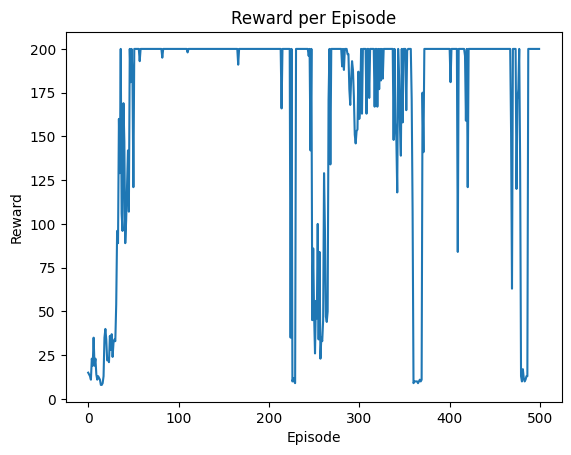

In [8]:
num_episodes = 500
episode_rewards = []

for episode in range(num_episodes):
    state = env.reset()
    episode_reward = 0

    while True:
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
        action = agent.select_action(state_tensor)
        next_state, reward, done, _ = env.step(action)
        agent.remember((state, action, next_state, reward, done))
        agent.replay()

        state = next_state
        episode_reward += reward

        if done:
            break

    episode_rewards.append(episode_reward)
    if episode % 10 == 0:
        print(f"Episode {episode}, Reward: {episode_reward}")

# Plot episode rewards
plt.plot(episode_rewards)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Reward per Episode")
plt.show()

In [9]:
with gym.wrappers.Monitor(make_env(), directory="videos", force=True) as env_monitor:
    state = env_monitor.reset()
    done = False
    for _ in range(10000):
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
        action = agent.select_action(state)
        next_state, _, done, _ = env_monitor.step(action)
        state = next_state
        if done:
          break

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:505: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1` with the environment ID `CartPole-v1`.
  logger.warn(


In [10]:
# show video
import gym.wrappers
import sys
from pathlib import Path
from base64 import b64encode
from IPython.display import HTML
video_paths = sorted([s for s in Path('videos').iterdir() if s.suffix == '.mp4'])
video_path = video_paths[-1]  # You can also try other indices (if n_games>1)

if 'google.colab' in sys.modules:
    # https://stackoverflow.com/a/57378660/1214547
    with video_path.open('rb') as fp:
        mp4 = fp.read()
    data_url = 'data:video/mp4;base64,' + b64encode(mp4).decode()
else:
    data_url = str(video_path)

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(data_url))